# Dataset Creation notebook
This notebook creates the dataset by converting the an ECG image into 13 times series.
An image is read in, and a mask is applied which only preserves the pixel of the ECG curves in a 2D array which contains {1,0}

In [607]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path, sys, re
from scipy.fft import fft, fftfreq

# img_viewer function
The function img_viewer is used to plot a sample ECG image file, along with the result of the digitization process. It plots the selected lead, and analyses it. A numerical result is overlayed on top of the image, and the baseline is the average of pixel locations.

In [600]:
def img_viewer(image_file_name,lead_dict,threshold):

    """
    This function loads the file specified in "image_file".
    It then plots the lead specified, and its fit
    """
   
    img_arr=cv2.imread(image_file_name)


    # These are the image limits in the array for each of the leads
    xlow = lead_dict["xlow"]
    xhigh = lead_dict["xhigh"]
    ylow = lead_dict["ylow"]
    yhigh = lead_dict["yhigh"]

    # this is the baseline of the lead
    baseline = lead_dict["baseline"]


    # read the image
    lead_arr = ((cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)[ylow:yhigh,xlow:xhigh][::-1,:].transpose() ))#).astype("int")
    lead_arr = lead_arr < threshold

    # average the location of the y value based on the number of "on = 1" pixel at each x value
    ysums = np.sum(lead_arr,axis=1)
    # array of indices with length of the y-axis, for each x-index
    indmat = ((np.arange(lead_arr.shape[1]))*np.ones(lead_arr.shape[0]).reshape(-1,1))

    # perform the average, and subtract the baseline
    # note that this can result in NaN for columns with 0 pixels on.
    # we take care of that later
    # here, we do not subtract the baseline, but rather plot it
    series_vals = np.sum(lead_arr*indmat,axis=1) / ysums #- baseline

    #fill in blanks using pd.series.fillna
    series_vals = pd.Series(series_vals)
    series_vals.fillna(method="ffill",inplace=True)
    series_vals.fillna(method="bfill",inplace=True)
    series_vals = series_vals.to_numpy()
    
    
    avg = np.mean(series_vals[(series_vals!=0) & (np.logical_not(np.isnan(series_vals))) ])
    print(avg)
    
    # plot the results
    plt.figure(figsize=(24,15))
    plt.scatter(np.arange(len(series_vals)),series_vals)
    plt.plot(np.arange(len(series_vals)),series_vals,"-r")
    plt.imshow(lead_arr.transpose(),cmap="gray",origin="lower")
#    plt.plot(np.arange(len(series_vals)),baseline*np.ones(len(series_vals)),"-y")
    
    plt.plot(np.arange(len(series_vals)),avg*np.ones(len(series_vals)),"-w")
    

# read_leads function
The function read_leads applies the digitization analysis to the an ECG image file.
Each lead is digitized, and the function returns a numpy array with results for all leads

In [601]:
def read_leads(image_file_name,lead_dict,threshold):
    """
    This function loads the file specified in "image_file".
    The 13 coordinates in lead_dicts are used to sparate the image into 13 separate images.
    The function applies a mask to each image, and returns a 1D numpy array for each sub-image.
    Each 1D array contains the average coordinates of the ECG lead.
    """
    
    img_arr=cv2.imread(image_file_name)

    all_leads = np.array([])


    for lead in lead_dict:
        
        # These are the image limits in the array for each of the leads
        xlow = lead_dict[lead]["xlow"]
        xhigh = lead_dict[lead]["xhigh"]
        ylow = lead_dict[lead]["ylow"]
        yhigh = lead_dict[lead]["yhigh"]
        
        # this is the baseline of the lead
        baseline = lead_dict[lead]["baseline"]
        
        
        # read the image
        lead_arr = ((cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)[ylow:yhigh,xlow:xhigh][::-1,:].transpose() ))#).astype("int")
        lead_arr = lead_arr < threshold

        # average the location of the y value based on the number of "on = 1" pixel at each x value
        ysums = np.sum(lead_arr,axis=1)
        # array of indices with length of the y-axis, for each x-index
        indmat = ((np.arange(lead_arr.shape[1]))*np.ones(lead_arr.shape[0]).reshape(-1,1))
        
        # perform the average, and subtract the baseline
        # note that this can result in NaN for columns with 0 pixels on.

#        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums - baseline

        # alternatively average all y-values and use the result as the baseline
        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums
        
        #fill in blanks using pd.series.fillna
        series_vals = pd.Series(series_vals)
        series_vals.fillna(method="ffill",inplace=True)
        series_vals.fillna(method="bfill",inplace=True)
        series_vals = series_vals.to_numpy()
        
        avg = np.mean(series_vals[(series_vals!=0) & (np.logical_not(np.isnan(series_vals))) ])
        series_vals = series_vals - avg
        
        
        all_leads= np.concatenate((all_leads,series_vals))

    
    return all_leads

# read_leads_fft function
The same as read_leads, but returns the spectral shape, i.e. the np.abs(fft(vals)

In [614]:
def read_leads_fft(image_file_name,lead_dict,threshold):
    """
    This function loads the file specified in "image_file".
    The 13 coordinates in lead_dicts are used to sparate the image into 13 separate images.
    The function applies a mask to each image, and returns a 1D numpy array for each sub-image.
    Each 1D array contains the average coordinates of the ECG lead.
    """
    
    img_arr=cv2.imread(image_file_name)

    all_leads = np.array([])


    for lead in lead_dict:
        
        # These are the image limits in the array for each of the leads
        xlow = lead_dict[lead]["xlow"]
        xhigh = lead_dict[lead]["xhigh"]
        ylow = lead_dict[lead]["ylow"]
        yhigh = lead_dict[lead]["yhigh"]
        
        # this is the baseline of the lead
        baseline = lead_dict[lead]["baseline"]
        
        
        # read the image
        lead_arr = ((cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)[ylow:yhigh,xlow:xhigh][::-1,:].transpose() ))#).astype("int")
        lead_arr = lead_arr < threshold

        # average the location of the y value based on the number of "on = 1" pixel at each x value
        ysums = np.sum(lead_arr,axis=1)
        # array of indices with length of the y-axis, for each x-index
        indmat = ((np.arange(lead_arr.shape[1]))*np.ones(lead_arr.shape[0]).reshape(-1,1))
        
        # perform the average, and subtract the baseline
        # note that this can result in NaN for columns with 0 pixels on.

#        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums - baseline

        # alternatively average all y-values and use the result as the baseline
        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums
        
        
        #fill in blanks using pd.series.fillna
        series_vals = pd.Series(series_vals)
        series_vals.fillna(method="ffill",inplace=True)
        series_vals.fillna(method="bfill",inplace=True)
        series_vals = series_vals.to_numpy()

        
        avg = np.mean(series_vals[(series_vals!=0) & (np.logical_not(np.isnan(series_vals))) ])
        series_vals = series_vals - avg
        
        series_vals = np.abs(fft(series_vals))
        
        all_leads= np.concatenate((all_leads,series_vals))

    
    return all_leads

# format1 dictionary

In [603]:
# This is the dictionary for the leads in the regular format.
# The baseline input is not used at the moment. Instead, the average pixel height is used.

lead_dict_format1 = {"lead_I":{"ylow":360,"yhigh":560,"xlow":180,"xhigh":640,"baseline":96},
                    "lead_II":{"ylow":660,"yhigh":860,"xlow":180,"xhigh":640,"baseline":96},
                    "lead_III":{"ylow":960,"yhigh":1160,"xlow":180,"xhigh":640,"baseline":93},
                    "lead_aVR":{"ylow":360,"yhigh":560,"xlow":700,"xhigh":1130,"baseline":96},
                    "lead_aVL":{"ylow":660,"yhigh":860,"xlow":700,"xhigh":1130,"baseline":96},
                    "lead_aVF":{"ylow":960,"yhigh":1160,"xlow":700,"xhigh":1130,"baseline":93},
                    "lead_V1":{"ylow":360,"yhigh":560,"xlow":1170,"xhigh":1620,"baseline":96},
                    "lead_V2":{"ylow":660,"yhigh":860,"xlow":1170,"xhigh":1620,"baseline":96},
                    "lead_V3":{"ylow":960,"yhigh":1160,"xlow":1170,"xhigh":1620,"baseline":93},

                    "lead_V4":{"ylow":360,"yhigh":560,"xlow":1660,"xhigh":2120,"baseline":96},
                    "lead_V5":{"ylow":660,"yhigh":860,"xlow":1660,"xhigh":2120,"baseline":96},
                    "lead_V6":{"ylow":960,"yhigh":1160,"xlow":1660,"xhigh":2120,"baseline":93},
                    "lead_long":{"ylow":1260,"yhigh":1460,"xlow":180,"xhigh":2120,"baseline":93},
                   }

# The threshold for filtering noise and the milimetric sheet grid in the regular format
threshold_format1 = 30

# Paths to the different ECG categories

In [585]:
# The list of directories for the 5 different ECG categories
path_NormalPersonECGImages = "data_v1/NormalPersonECGImages/"
path_ECGImagesofPatientthathaveabnormalheartbeats = "data_v1/ECGImagesofPatientthathaveabnormalheartbeats/"
path_ECGImagesofPatientthathaveHistoryofMI = "data_v1/ECGImagesofPatientthathaveHistoryofMI/"
path_ECGImagesofMyocardialInfarctionPatients = "data_v1/ECGImagesofMyocardialInfarctionPatients/"
path_ECGImagesofCOVID19Patients = "data_v1/ECGImagesofCOVID-19Patients/"

# Getting results

In [586]:
# This function accepts a list of ECG image file paths and reutrns the feature array of all leads for each image
def get_results(path_list):
    results = []
    for file_name in path_list:
        results.append(read_leads(file_name,lead_dict_normal,threshold_normal) )
    results = (np.column_stack(results)).transpose()
    
    return results

In [609]:
# This function accepts a list of ECG image file paths and reutrns the feature array of all leads for each image
def get_results_fft(path_list):
    results = []
    for file_name in path_list:
        results.append(read_leads_fft(file_name,lead_dict_normal,threshold_normal) )
    results = (np.column_stack(results)).transpose()
    
    return results

# Build the format ECG image file lists
Here, we build the list of files in each category, which falls into format1

In [587]:
NormalPersonECGImages1 = sorted([path_NormalPersonECGImages+file for file in os.listdir(path_NormalPersonECGImages)])
ECGImagesofPatientthathaveabnormalheartbeats1 = sorted([path_ECGImagesofPatientthathaveabnormalheartbeats+file 
                                                        for file in 
                                                os.listdir(path_ECGImagesofPatientthathaveabnormalheartbeats)
                                                if int(file.replace("_",".").split(".")[1])<400])
ECGImagesofPatientthathaveHistoryofMI1 = sorted([path_ECGImagesofPatientthathaveHistoryofMI+file for file in 
                                                os.listdir(path_ECGImagesofPatientthathaveHistoryofMI)
                                                if int(file.replace("_",".").split(".")[1])<113])
ECGImagesofMyocardialInfarctionPatients1 = sorted([path_ECGImagesofMyocardialInfarctionPatients+file for file in 
                                                os.listdir(path_ECGImagesofMyocardialInfarctionPatients)
                                                if int(file.replace("_",".").split(".")[1])<37])

format1_categories = [NormalPersonECGImages1, ECGImagesofPatientthathaveabnormalheartbeats1, 
                      ECGImagesofPatientthathaveHistoryofMI1,ECGImagesofMyocardialInfarctionPatients1]

In [588]:
# Number of samples in format1 for each category
print(
    len(NormalPersonECGImages1),
    len(ECGImagesofPatientthathaveabnormalheartbeats1),
    len(ECGImagesofPatientthathaveHistoryofMI1),
    len(ECGImagesofMyocardialInfarctionPatients1)
)

859 397 112 36


# Get datasets
Here, we run the analysis code over the entire format1 dataset.
This includes the format1 images in all 4 categories above.
Each category is assigned a category index, 0-3

In [597]:
res_all = []
for category_ind, category in enumerate(format1_categories[:]):
    res = get_results(category)
    res = np.concatenate((res,category_ind*np.ones(res.shape[0]).reshape(-1,1)),axis=1)
    res_all.append(res)

<ipython-input-594-4000f2e6422a>:41: RuntimeWarning: invalid value encountered in true_divide
  series_vals = np.sum(lead_arr*indmat,axis=1) / ysums


In [617]:
res_all_fft = []
for category_ind, category in enumerate(format1_categories[:]):
    res = get_results_fft(category)
    res = np.concatenate((res,category_ind*np.ones(res.shape[0]).reshape(-1,1)),axis=1)
    res_all_fft.append(res)

<ipython-input-614-02a5a4fb1145>:41: RuntimeWarning: invalid value encountered in true_divide
  series_vals = np.sum(lead_arr*indmat,axis=1) / ysums


Combine all the list of results for each category into a big numpy array

In [618]:
format1_dataset = np.concatenate(res_all)
format1_dataset_fft = np.concatenate(res_all_fft)

Convert the big result numpy array into a dataframe, and save it to a CSV file

In [605]:
pd.DataFrame(format1_dataset).to_csv("time_series_data_v1.csv")

In [619]:
pd.DataFrame(format1_dataset_fft).to_csv("time_series_data_v1_fft.csv")

# Image Viewing
The img-viewer function is used to plot a sample lead digitization analysis of a given ECG image file

95.80279072523706


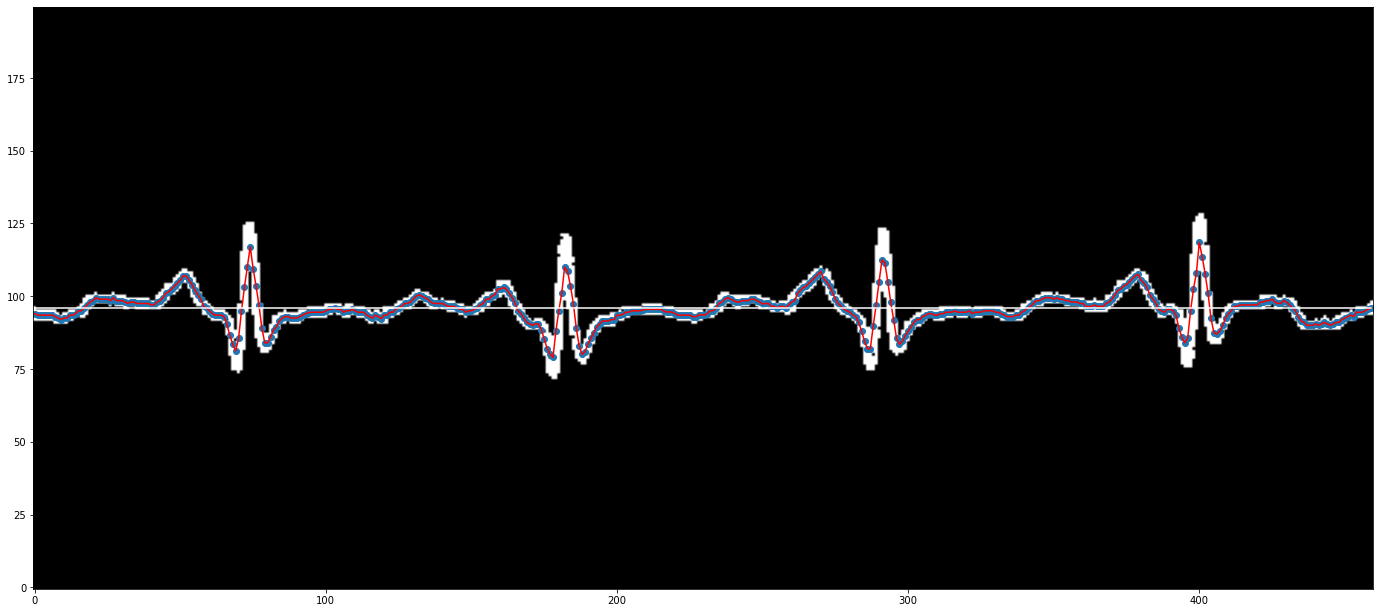

In [625]:
# here you can plug in any ECG image file
img_viewer("data_v1/NormalPersonECGImages/Normal_5.jpg",
           lead_dict_format1["lead_II"],
           threshold_format1 )